In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import RIMUnet, PhysicalModel, RIM, RIMSharedUnet
from censai.models import VAE, VAESecondStage, SharedUnetModel
from censai.utils import rim_residual_plot, update
from censai.data.lenses_tng import decode_train, decode_physical_model_info
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math, json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 100)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

# Scale Dataset 512 k128

In [2]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_SDS.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,gru_kernel_size,upsampling_interpolation,kernel_regularizer_amp,bias_regularizer_amp,activation,alpha,initializer,kappa_resize_filters,kappa_resize_method,kappa_resize_conv_layers,kappa_resize_strides,kappa_resize_kernel_size,kappa_resize_separate_grad_downsampling,batch_size,total_items,optimizer,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score
1,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,100,Adam,42,RIMSU512_k128_SDS_001_TI100_B5_210724195848,0.025559,0.038752,0.720245,3.735015,0.025560
0,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,100,Adam,42,RIMSU512_k128_SDS_000_TI100_B1_210724195848,0.001692,0.038476,0.336212,0.473320,0.001581
2,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,10,100,Adam,42,RIMSU512_k128_SDS_002_TI100_B10_210724195848,0.008426,0.052196,0.723703,0.144652,0.005711
5,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,10,500,Adam,42,RIMSU512_k128_SDS_005_TI500_B10_210724195901,0.010447,0.038988,0.592514,1.274803,0.009382
4,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,500,Adam,42,RIMSU512_k128_SDS_004_TI500_B5_210724195901,0.002829,0.043254,0.786680,0.621704,0.002766
6,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SDS_006_TI1000_B1_210724195901,0.007893,0.043945,1.011483,0.362284,0.006471
3,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,500,Adam,42,RIMSU512_k128_SDS_003_TI500_B1_210724195848,0.002281,0.040195,1.336384,3.795889,0.001447
7,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,5,1000,Adam,42,RIMSU512_k128_SDS_007_TI1000_B5_210724195901,0.002372,0.046019,1.083795,6.135693,0.002004
14,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,10,10000,Adam,42,RIMSU512_k128_SDS_014_TI10000_B10_210724201140,0.018998,0.033625,1.791118,1.867243,0.018986
12,4,True,True,False,identity,0.1,0.001,16,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SDS_012_TI10000_B1_210724200956,0.015071,0.056759,2.578048,1.204411,0.015071


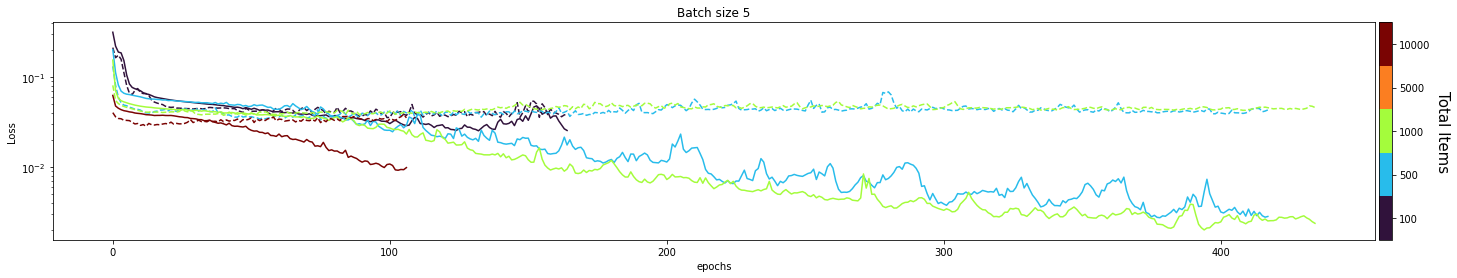

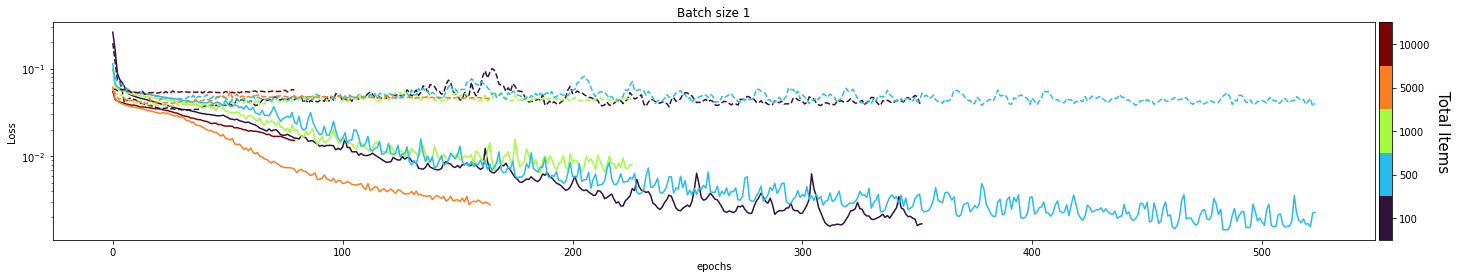

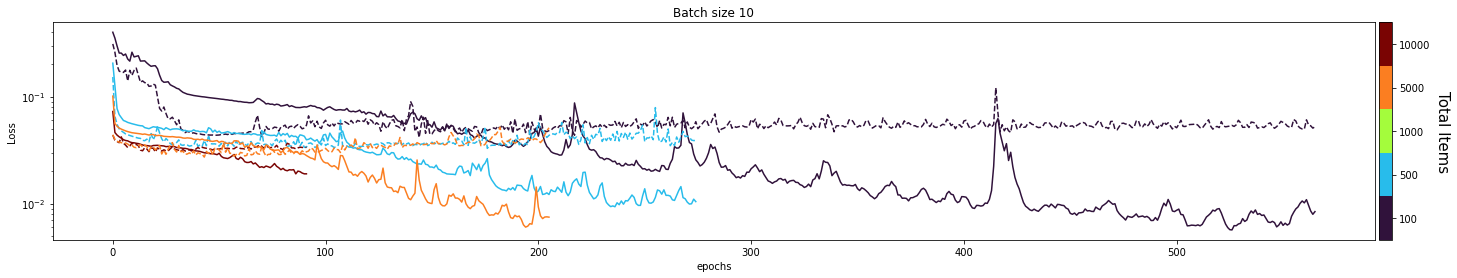

In [3]:
# This function formatter will replace integers with target names
ti = hparams["total_items"].unique()
ti.sort()
func_colors = lambda val: np.where(ti == val)[0][0]
formatter = plt.FuncFormatter(lambda val, loc: ti[val])

cmap = mpl.cm.get_cmap("turbo", ti.size)
norm  = mpl.colors.Normalize(vmin=0, vmax=ti.size)
for batch_size in hparams["batch_size"].unique():
    plt.figure(figsize=(24, 4))
    ax = plt.gca()
    for experiment_id, curves in histories.items():
        epochs = curves
        total_items = hparams[(hparams["experiment_id"] == experiment_id) & (hparams["batch_size"] == batch_size)]["total_items"].to_numpy()
        if total_items.size != 0:
            plt.plot([curves["train_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="-", color=cmap(func_colors(total_items[0])))
            plt.plot([curves["val_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="--", color=cmap(func_colors(total_items[0])))

    plt.title(f"Batch size {batch_size}")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_clim(-0.5, 4.5)
    cbar = plt.colorbar(mappable, cax=cax, ticks=range(5), format=formatter)
    cbar.ax.set_ylabel('Total Items', rotation=270, fontsize=15, labelpad=20)

# Scale Filters 512 k128

In [4]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_SF.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,gru_kernel_size,upsampling_interpolation,kernel_regularizer_amp,bias_regularizer_amp,activation,alpha,initializer,kappa_resize_filters,kappa_resize_method,kappa_resize_conv_layers,kappa_resize_strides,kappa_resize_kernel_size,kappa_resize_separate_grad_downsampling,batch_size,total_items,optimizer,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score
10,4,True,True,False,identity,0.1,0.001,32,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_010_F32_FS2_TI1000_210724203621,0.002761,0.036436,0.675994,2.034342,0.002239
8,4,True,True,False,identity,0.1,0.001,32,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_008_F32_FS1_TI1000_210724203213,0.004284,0.107336,1.393330,0.388692,0.003074
16,4,True,True,False,identity,0.1,0.001,128,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_016_F128_FS1_TI1000_210724204959,0.004360,0.039590,1.649343,0.612472,0.003358
12,4,True,True,False,identity,0.1,0.001,64,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_012_F64_FS1_TI1000_210724203758,0.001237,0.040772,0.421450,0.432474,0.001040
17,4,True,True,False,identity,0.1,0.001,128,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SF_017_F128_FS1_TI10000_21072420...,0.026501,0.036085,2.338043,6.232780,0.026501
15,4,True,True,False,identity,0.1,0.001,64,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SF_015_F64_FS2_TI10000_210724204251,0.033234,0.044767,2.760810,2.199440,0.033188
5,4,True,True,False,identity,0.1,0.001,16,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SF_005_F16_FS1_TI10000_210724202341,0.035782,0.039258,1.854065,0.935480,0.035782
3,4,True,True,False,identity,0.1,0.001,8,2,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SF_003_F8_FS2_TI10000_210724201345,0.017679,0.036406,1.467147,1.667062,0.016941
0,4,True,True,False,identity,0.1,0.001,8,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,1000,Adam,42,RIMSU512_k128_SF_000_F8_FS1_TI1000_210724201345,0.018930,0.040419,1.126049,0.684670,0.018296
9,4,True,True,False,identity,0.1,0.001,32,1,3,3,2,2,NaN,NaN,5,5,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,10000,Adam,42,RIMSU512_k128_SF_009_F32_FS1_TI10000_210724203627,0.035443,0.034244,2.248661,1.762354,0.035785


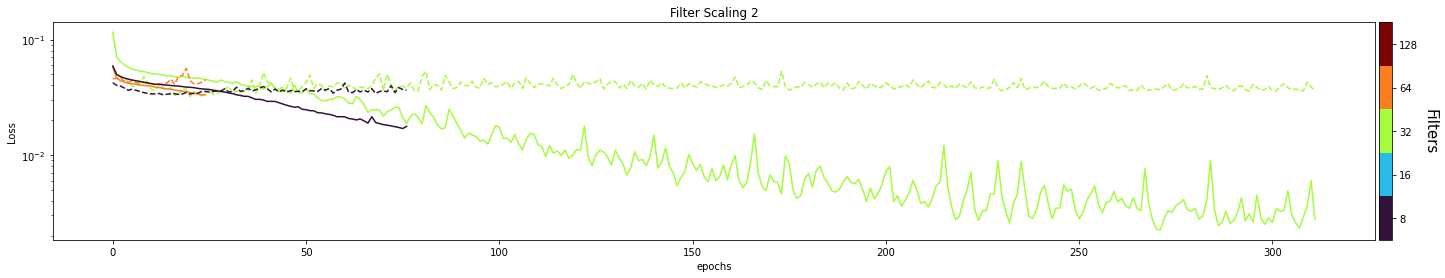

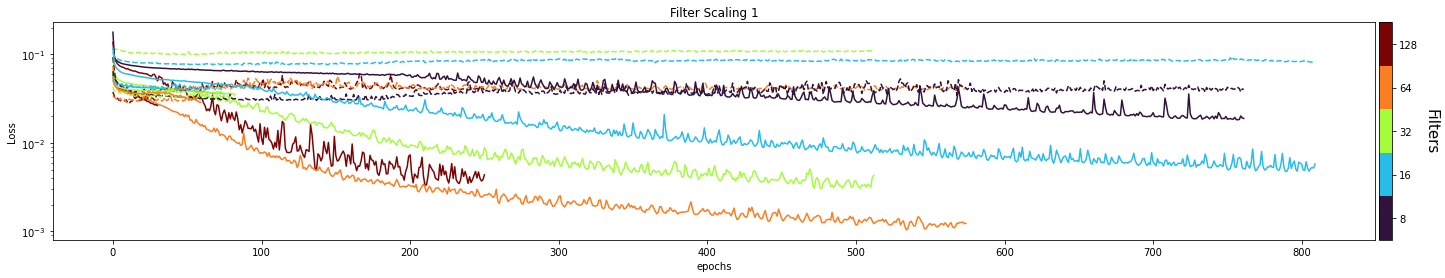

In [5]:
# This function formatter will replace integers with target names
ti = hparams["filters"].unique()
ti.sort()
func_colors = lambda val: np.where(ti == val)[0][0]
formatter = plt.FuncFormatter(lambda val, loc: ti[val])

cmap = mpl.cm.get_cmap("turbo", ti.size)
norm  = mpl.colors.Normalize(vmin=0, vmax=ti.size)
for fs in hparams["filter_scaling"].unique():
    plt.figure(figsize=(24, 4))
    ax = plt.gca()
    for experiment_id, curves in histories.items():
        epochs = curves
        filters = hparams[(hparams["experiment_id"] == experiment_id) & (hparams["filter_scaling"] == fs)]["filters"].to_numpy()
        if filters.size != 0:
            plt.plot([curves["train_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="-", color=cmap(func_colors(filters[0])))
            plt.plot([curves["val_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="--", color=cmap(func_colors(filters[0])))

    plt.title(f"Filter Scaling {fs}")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_clim(-0.5, 4.5)
    cbar = plt.colorbar(mappable, cax=cax, ticks=range(ti.size), format=formatter)
    cbar.ax.set_ylabel('Filters', rotation=270, fontsize=15, labelpad=20)

# Scale Filters Doube Unet 512 k128

In [6]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_SF.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,kappa_filters,kappa_filter_scaling,kappa_kernel_size,kappa_layers,kappa_block_conv_layers,kappa_strides,kappa_bottleneck_kernel_size,kappa_bottleneck_filters,kappa_resampling_kernel_size,kappa_gru_kernel_size,kappa_upsampling_interpolation,kappa_kernel_regularizer_amp,kappa_bias_regularizer_amp,kappa_activation,kappa_alpha,kappa_initializer,source_filters,source_filter_scaling,source_kernel_size,source_layers,source_block_conv_layers,source_strides,source_bottleneck_kernel_size,source_bottleneck_filters,source_resampling_kernel_size,source_gru_kernel_size,source_upsampling_interpolation,source_kernel_regularizer_amp,source_bias_regularizer_amp,source_activation,source_alpha,source_initializer,batch_size,total_items,optimizer,seed,experiment_id,train_cost,val_cost,train_chi_squared,val_chi_squared,best_score
6,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,16,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_006_KF8_KFS1_SF16_SFS1_TI100_...,0.137077,0.076825,1.585635,0.940115,0.127806
18,4,True,True,False,identity,0.1,0.001,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_018_KF8_KFS2_SF8_SFS1_TI100_2...,0.090064,0.073056,0.899679,0.585395,0.053220
3,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_003_KF8_KFS1_SF8_SFS2_TI100_2...,0.073911,0.071003,4.278298,1.188687,0.069472
9,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,16,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_009_KF8_KFS1_SF16_SFS2_TI100_...,0.130505,0.091099,0.893249,1.023779,0.123990
21,4,True,True,False,identity,0.1,0.001,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_021_KF8_KFS2_SF8_SFS2_TI100_2...,0.156125,0.069874,0.649548,0.298799,0.131776
0,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_000_KF8_KFS1_SF8_SFS1_TI100_2...,0.075316,0.125067,0.800309,0.608770,0.060057
12,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,32,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_012_KF8_KFS1_SF32_SFS1_TI100_...,0.078159,0.114082,1.050533,43.696957,0.078572
27,4,True,True,False,identity,0.1,0.001,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,16,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_027_KF8_KFS2_SF16_SFS2_TI100_...,0.077942,0.062750,2.050091,1.910683,0.072682
24,4,True,True,False,identity,0.1,0.001,8,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,16,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_024_KF8_KFS2_SF16_SFS1_TI100_...,0.140370,0.089409,2.393085,0.468036,0.139889
15,4,True,True,False,identity,0.1,0.001,8,1,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,32,2,3,4,3,2,NaN,NaN,NaN,NaN,True,0.0,0.0,leaky_relu,0.2,glorot_normal,1,100,Adam,42,RIMDU512_k128_SF_015_KF8_KFS1_SF32_SFS2_TI100_...,0.080534,0.103285,0.859605,1.862267,0.051669


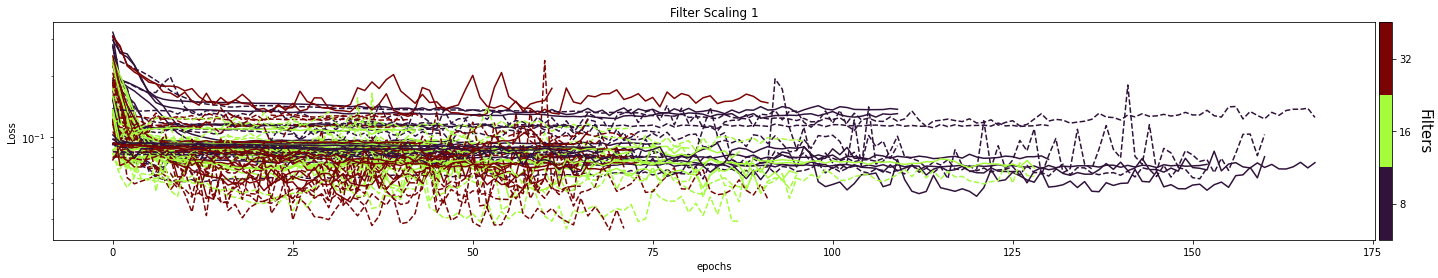

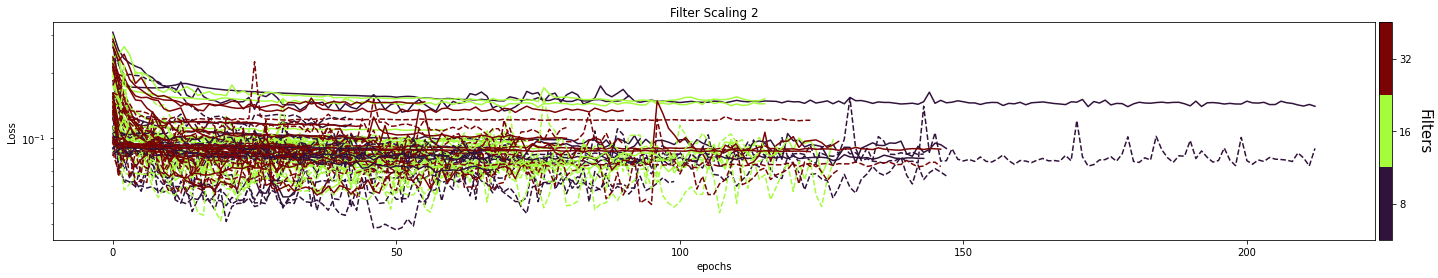

In [7]:
# This function formatter will replace integers with target names
ti = hparams["kappa_filters"].unique()
ti.sort()
func_colors = lambda val: np.where(ti == val)[0][0]
formatter = plt.FuncFormatter(lambda val, loc: ti[val])

cmap = mpl.cm.get_cmap("turbo", ti.size)
norm  = mpl.colors.Normalize(vmin=0, vmax=ti.size)
for fs in hparams["kappa_filter_scaling"].unique():
    plt.figure(figsize=(24, 4))
    ax = plt.gca()
    for experiment_id, curves in histories.items():
        epochs = curves
        filters = hparams[(hparams["experiment_id"] == experiment_id) & (hparams["kappa_filter_scaling"] == fs)]["kappa_filters"].to_numpy()
        if filters.size != 0:
            plt.plot([curves["train_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="-", color=cmap(func_colors(filters[0])))
            plt.plot([curves["val_cost"][i] for i in sorted(curves["train_cost"].keys())], ls="--", color=cmap(func_colors(filters[0])))

    plt.title(f"Filter Scaling {fs}")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_clim(-0.5, 2.5)
    cbar = plt.colorbar(mappable, cax=cax, ticks=range(ti.size), format=formatter)
    cbar.ax.set_ylabel('Filters', rotation=270, fontsize=15, labelpad=20)

# RIMSU wVAE

In [81]:
hparams = pd.read_csv(os.path.join(result_dir, "RIMSU_wVAE2.csv"), index_col=0)
histories = {}
for file in hparams["experiment_id"]:
    histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams

,steps,adam,kappalog,kappa_normalize,source_link,kappa_init,source_init,filters,filter_scaling,kernel_size,layers,block_conv_layers,strides,bottleneck_kernel_size,bottleneck_filters,resampling_kernel_size,gru_kernel_size,upsampling_interpolation,kernel_regularizer_amp,bias_regularizer_amp,activation,alpha,initializer,kappa_resize_filters,kappa_resize_method,kappa_resize_conv_layers,kappa_resize_strides,kappa_resize_kernel_size,kappa_resize_separate_grad_downsampling,batch_size,total_items,optimizer,initial_learning_rate,decay_rate,decay_steps,seed,experiment_id,cost,chi_squared,kappa_cost,source_cost,bext_score
5,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,3,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,100000,42,RIMSU_wVAE_005_TS2_BCL3_NLleaky_relu_ds100000_210907170847,NaN,9.764476e-01,NaN,NaN,0.047465
1,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,2,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,100000,42,RIMSU_wVAE_001_TS2_BCL2_NLleaky_relu_ds100000_210907165039,NaN,1.072070e+00,NaN,NaN,0.023477
9,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,4,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,100000,42,RIMSU_wVAE_009_TS2_BCL4_NLleaky_relu_ds100000_210907171014,NaN,1.126503e+00,NaN,NaN,0.035606
8,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,4,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,200000,42,RIMSU_wVAE_008_TS2_BCL4_NLleaky_relu_ds200000_210907171014,NaN,4.048368e+00,NaN,NaN,0.055870
4,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,3,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,200000,42,RIMSU_wVAE_004_TS2_BCL3_NLleaky_relu_ds200000_210907165410,NaN,1.076036e+00,NaN,NaN,0.023928
10,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,4,2,NaN,NaN,5,3,False,0.0001,0.0001,bipolar_leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,200000,42,RIMSU_wVAE_010_TS2_BCL4_NLbipolar_leaky_relu_ds200000_210907171014,NaN,1.963124e+00,NaN,NaN,0.072790
6,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,3,2,NaN,NaN,5,3,False,0.0001,0.0001,bipolar_leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,200000,42,RIMSU_wVAE_006_TS2_BCL3_NLbipolar_leaky_relu_ds200000_210907170939,NaN,1.163685e+00,NaN,NaN,0.027964
11,2,True,True,False,relu,0.1,0.001,32,2.0,3,3,4,2,NaN,NaN,5,3,False,0.0001,0.0001,bipolar_leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,100000,42,RIMSU_wVAE_011_TS2_BCL4_NLbipolar_leaky_relu_ds100000_210907171018,NaN,1.768134e+00,NaN,NaN,0.025217
19,4,True,True,False,relu,0.1,0.001,32,2.0,3,3,3,2,NaN,NaN,5,3,False,0.0001,0.0001,bipolar_leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,100000,42,RIMSU_wVAE_019_TS4_BCL3_NLbipolar_leaky_relu_ds100000_210907173016,NaN,1.975195e+00,NaN,NaN,inf
20,4,True,True,False,relu,0.1,0.001,32,2.0,3,3,4,2,NaN,NaN,5,3,False,0.0001,0.0001,leaky_relu,0.1,glorot_normal,4,bilinear,1,2,3,False,1,2000,ADAM,0.0005,0.5,200000,42,RIMSU_wVAE_020_TS4_BCL4_NLleaky_relu_ds200000_210907173016,NaN,1.943834e+00,NaN,NaN,inf


In [2]:
kappa_first_stage_vae=os.path.join(os.getenv("CENSAI_PATH"), "models/VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741")
kappa_second_stage_vae=os.path.join(os.getenv("CENSAI_PATH"), "models/VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741_second_stage_210813104442")
source_first_stage_vae=os.path.join(os.getenv("CENSAI_PATH"), "models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842")
source_second_stage_vae=os.path.join(os.getenv("CENSAI_PATH"), "models/VAE1_cosmos_HPARAMS_029_L3_CL4_F16_NLleaky_relu_LS128_ssi0.001_210810161842_second_stage_210812235647")


model = kappa_first_stage_vae
with open(os.path.join(model, "model_hparams.json"), "r") as f:
    vae_hparams = json.load(f)
kappa_first_stage_vae = VAE(**vae_hparams)
ckpt1 = tf.train.Checkpoint(net=kappa_first_stage_vae)
checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, model, 1)
checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()

model = source_first_stage_vae
with open(os.path.join(model, "model_hparams.json"), "r") as f:
    vae_hparams = json.load(f)
source_first_stage_vae = VAE(**vae_hparams)
ckpt1 = tf.train.Checkpoint(net=source_first_stage_vae)
checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, model, 1)
checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()


second_stage = kappa_second_stage_vae
with open(os.path.join(second_stage, "model_hparams.json"), "r") as f:
    vae2_hparams = json.load(f)
kappa_second_stage_vae = VAESecondStage(**vae2_hparams)
ckpt2 = tf.train.Checkpoint(net=kappa_second_stage_vae)
checkpoint_manager2 = tf.train.CheckpointManager(ckpt2, second_stage, 1)
checkpoint_manager2.checkpoint.restore(checkpoint_manager2.latest_checkpoint).expect_partial()

second_stage = source_second_stage_vae
with open(os.path.join(second_stage, "model_hparams.json"), "r") as f:
    vae2_hparams = json.load(f)
source_second_stage_vae = VAESecondStage(**vae2_hparams)
ckpt2 = tf.train.Checkpoint(net=source_second_stage_vae)
checkpoint_manager2 = tf.train.CheckpointManager(ckpt2, second_stage, 1)
checkpoint_manager2.checkpoint.restore(checkpoint_manager2.latest_checkpoint).expect_partial()

In [136]:
from argparse import Namespace
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU_wVAE_003_TS4_F32_L4_NLbipolar_relu_210816225310")
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU_wVAE_019_TS4_BCL3_NLbipolar_leaky_relu_ds100000_210910152719")
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU_wVAE_018_TS4_BCL3_NLbipolar_leaky_relu_ds200000_210910152719")
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU_wVAE_011_TS2_BCL4_NLbipolar_leaky_relu_ds100000_210910152708")
checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU_wVAE_005_TS2_BCL3_NLleaky_relu_ds100000_210910152707")


with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)
phys = PhysicalModel(
    pixels=args.image_pixels,
    kappa_pixels=128,
    src_pixels=128,
    image_fov=args.image_fov,
    kappa_fov=args.kappa_fov,
    src_fov=args.source_fov,
    method=args.forward_method,
    noise_rms=args.noise_rms,
    raytracer=None,
    psf_sigma=args.psf_sigma
)

unet = SharedUnetModel(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    bottleneck_filters=args.bottleneck_filters,
    resampling_kernel_size=args.resampling_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
    kernel_regularizer_amp=args.kernel_regularizer_amp,
    bias_regularizer_amp=args.bias_regularizer_amp,
    activation=args.activation,
    alpha=args.alpha,
    initializer=args.initializer,
)
rim = RIMSharedUnet(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    kappalog=args.kappalog,
    source_link=args.source_link,
    kappa_normalize=args.kappa_normalize,
    kappa_init=args.kappa_init,
    source_init=args.source_init
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

In [137]:
kappa = 10**kappa_first_stage_vae.decode(kappa_second_stage_vae.sample(10))
source = source_first_stage_vae.decode(source_second_stage_vae.sample(10))
source /= tf.reduce_max(source, axis=(1, 2, 3), keepdims=True)  # preprocess source
lens = tf.nn.relu(phys.noisy_forward(source, kappa, noise_rms=args.noise_rms))

source_pred, kappa_pred, chi = rim.predict(lens)
lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])

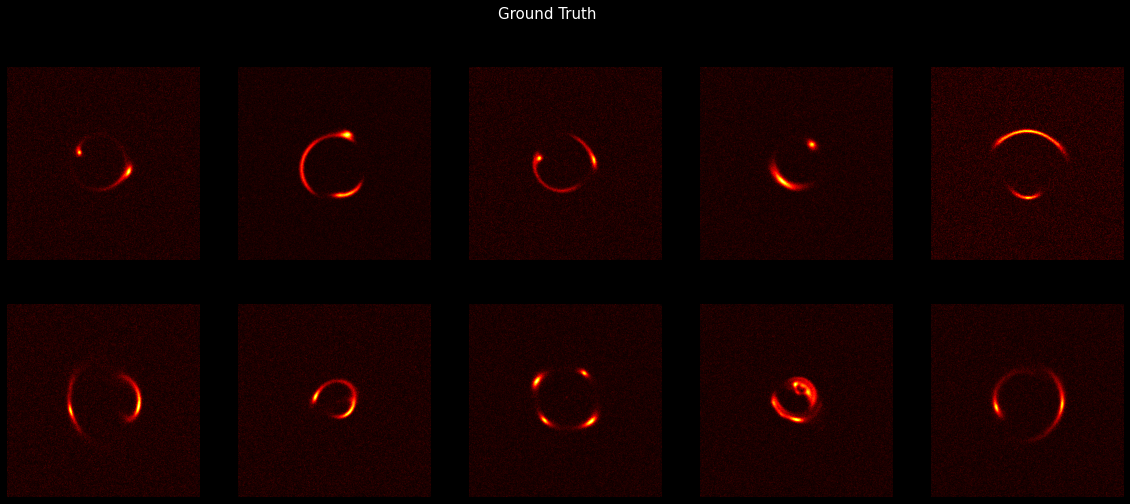

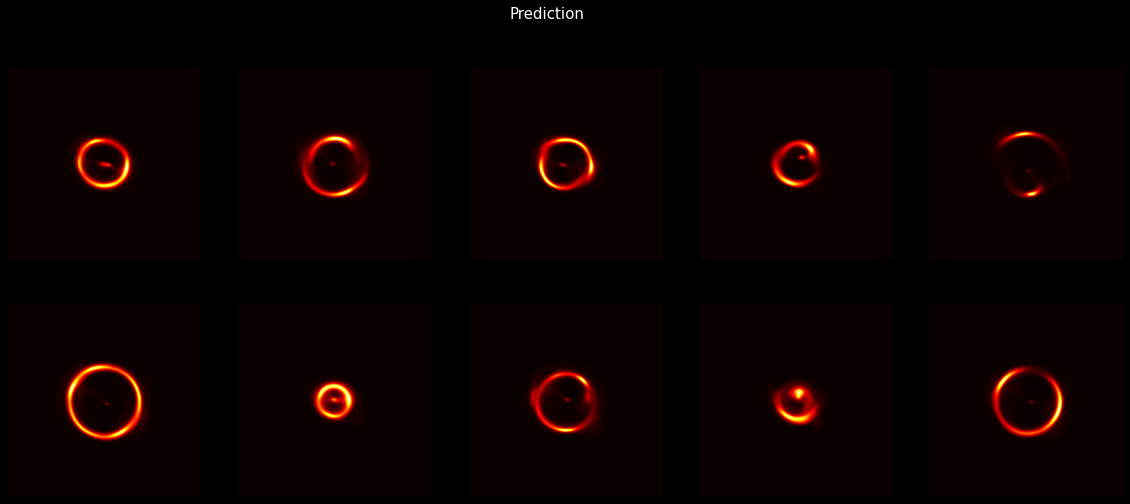

In [138]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Ground Truth", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(lens[k, ..., 0], cmap="hot")
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Prediction", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(lens_pred[k, ..., 0], cmap="hot")

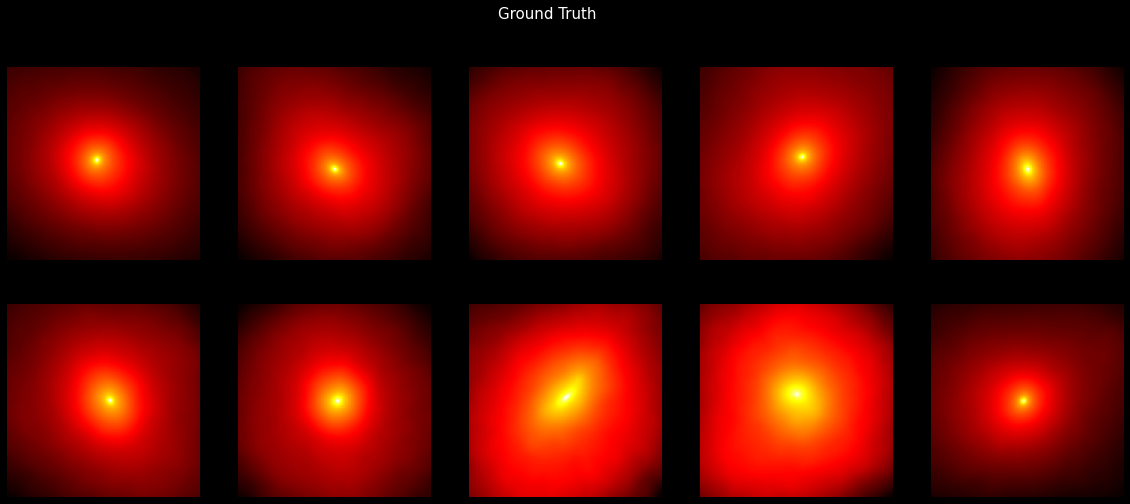

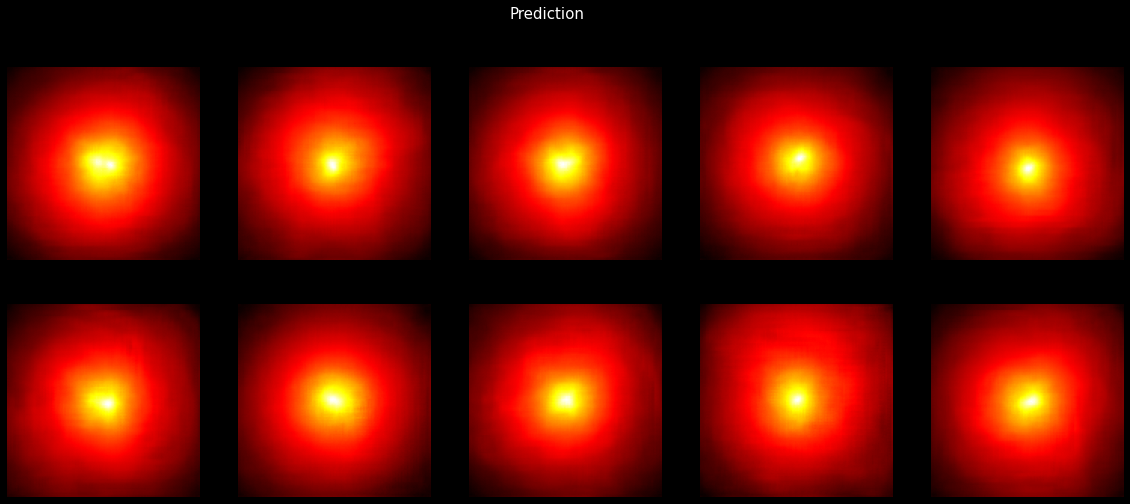

In [139]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Ground Truth", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(rim.kappa_inverse_link(kappa[k, ..., 0]), cmap="hot")
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Prediction", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(rim.kappa_inverse_link(kappa_pred[-1, k, ..., 0]), cmap="hot")

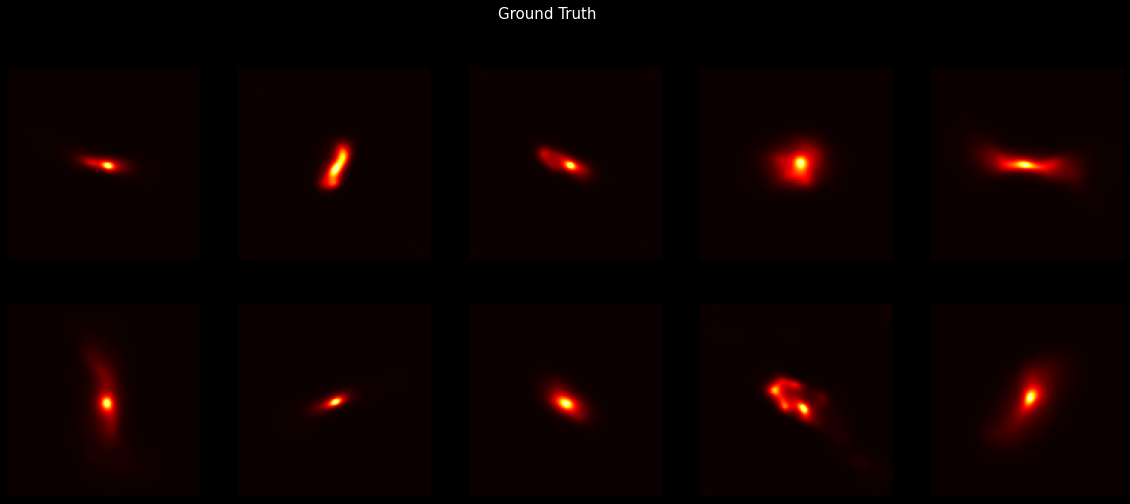

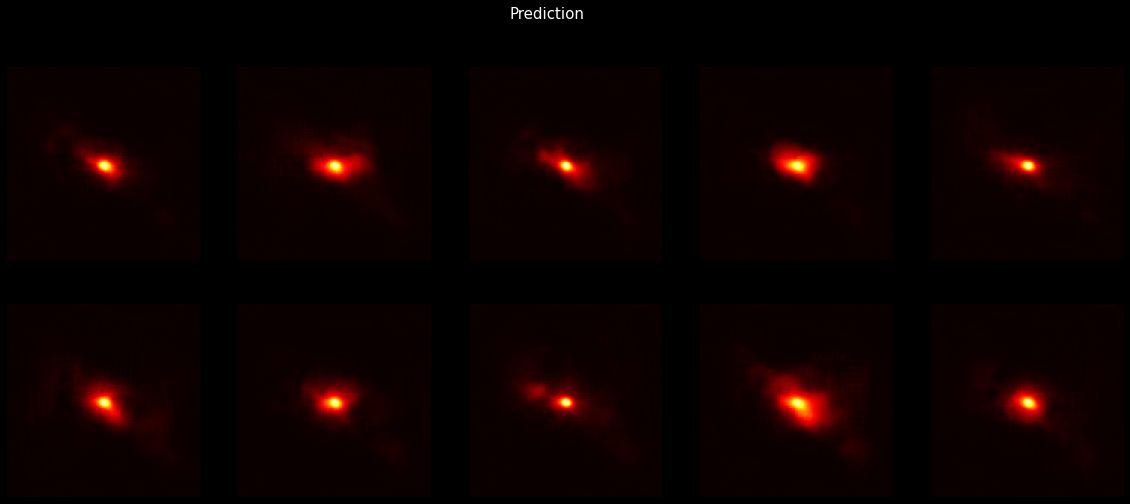

In [140]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Ground Truth", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(source[k, ..., 0], cmap="hot")
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Prediction", fontsize=15)
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].axis("off")
        axs[i, j].imshow(source_pred[-1, k, ..., 0], cmap="hot")